In [134]:
import numpy as np
from scipy import signal, sparse
import skimage as sk
import skimage.filters as sf
import skimage.io as skio
from skimage.io import imsave, imshow, show

from operations import *

In [19]:
impathT = 'sample_imgs/samples/toy_problem.png'
imT = skio.imread(impathT)
imT = sk.img_as_float(imT)

impathM = 'sample_imgs/spline/mask2.jpg'
imM = skio.imread(impathM)
imM = sk.img_as_float(imM)

In [21]:
b = np.array([[0, 3, 0]])
b.nonzero()

# imM.nonzero()

(array([0]), array([1]))

In [165]:
mask = np.ones(imT.shape)

def createNonZeroPairs(mask):
    #TODO extend
    if mask.ndim == 3:
        mask = np.squeeze(np.dsplit(mask, [1])[0], axis=2)
        # change 3 channel to 1 value per pixel,
        # specifically using the 0th channel's
    maskNonZero = mask.nonzero()
    
#    return maskNonZero
    
    nonZeroIndices = []
#    mask
    for i in range(len(maskNonZero[0])):
        nonZeroIndices.append((maskNonZero[0][i], maskNonZero[1][i]))
    
    return nonZeroIndices

#####
# mask.nonzero() ## assume it's 1D

def makeIm2Var(mask):
    nonZeroIndices = createNonZeroPairs(mask)

    dictIm2Var = dict()
    dictVar2Im = dict()
    
    dictRow2Cols = dict()
    dictCol2Rows = dict()

    fTup2Key = (lambda tup: "%i-%i" % tup)
    fYX2Key = (lambda y, x: fTup2Key((y, x)))

    for i in range(len(nonZeroIndices)):
        pair = nonZeroIndices[i]
        row, col = pair
        
        if row not in dictRow2Cols:
            dictRow2Cols[row] = []
        dictRow2Cols[row].append(col)
        
        if col not in dictCol2Rows:
            dictCol2Rows[col] = []
        dictCol2Rows[col].append(row)
        
        key = fTup2Key(pair)
        dictIm2Var[key] = i
        dictVar2Im[i] = pair

    im2Var = (lambda y, x: dictIm2Var[fYX2Key(y, x)])
    var2Im = (lambda x: dictVar2Im[x])
    
    # print(dictIm2Var)
    
    totalUnknowns = len(nonZeroIndices)
    
    return im2Var, var2Im, totalUnknowns, dictRow2Cols, dictCol2Rows

im2Var, var2Im, totalUnknowns, dictRow2Cols, dictCol2Rows = makeIm2Var(mask)

# im2Var(3, 2)

In [213]:

# totalUnknowns = rHeight * rWidth #change

"""
neg1_changeListY = []
neg1_changeListX = []

pos1_changeListY = []
pos1_changeListX = []

### X-DIR GRADIENTS
per y row:
    if size of region in this row is 1 or less:
        continue
    increase newLineCt
    for every pixel i in the row except last one:
        neg1_changeListY.append(newLineCt)
        neg1_changeListX.append(im2Var(y, i))
        
        pos1_changeListY.append(newLineCt)
        pos1_changeListX.append(im2Var(y, i+1))
        # first index = most left in region
        # last index = most right in region
per x cols:
    if size of region in this column is 1 or less:
        continue
    increase newLineCt
    for pix j in this col except last one:
        neg1_changeListY.append(newlineCt)
        neg1_changeListX.append(im2Var(j, x))
        
        pos1_changeListY.append(newlineCt)
        pos1_changeListX.append(im2Var(j+1, x))

"""

rHeight, rWidth = len(dictRow2Cols), len(dictCol2Rows)

neg1_changeListY = []
neg1_changeListX = []
pos1_changeListY = []
pos1_changeListX = []

# def neg1(y, x):

bList = []

newLineCt = -1
for y in range(rHeight):
    cols = dictRow2Cols[y]
    if len(cols) <= 1:
        continue
    
    for i in range(len(cols) - 1):
        col = cols[i]
        newLineCt += 1
        neg1_changeListY.append(newLineCt)
        neg1_changeListX.append(im2Var(y, col))

        pos1_changeListY.append(newLineCt)
        pos1_changeListX.append(im2Var(y, col+1))
        
        bList.append(imT[y, col+1] - imT[y, col])

for x in range(rWidth):
    rows = dictCol2Rows[x]
    if len(rows) <= 1:
        continue
        
    for j in range(len(rows) - 1):
        row = rows[j]
        newLineCt += 1
        neg1_changeListY.append(newLineCt)
        neg1_changeListX.append(im2Var(row, x))
        
        pos1_changeListY.append(newLineCt)
        pos1_changeListX.append(im2Var(row+1, x))
        
        bList.append(imT[row+1, x] - imT[row, x])
        
# print(neg1_changeListY)
# print(neg1_changeListX)
# print(pos1_changeListY)
# print(pos1_changeListX)

newLineCt += 1
pos1_changeListY.append(newLineCt)
pos1_changeListX.append(im2Var(0, 0))
bList.append(imT[0, 0])

newA = np.zeros((newLineCt + 1, totalUnknowns))

newA[neg1_changeListY,neg1_changeListX] = -1
newA[pos1_changeListY,pos1_changeListX] = 1

# newA
b = np.array(bList)

In [214]:
resolve = sparse.linalg.lsqr(newA, b)

/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


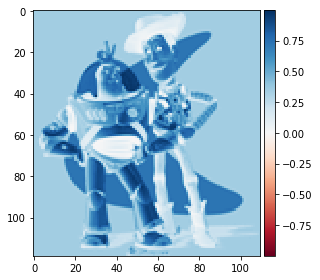

In [215]:
# reconstruct from solution 2 im

finalIm = np.zeros((rHeight, rWidth))

solution = resolve[0]

# for x in enumerate(solution):
#     print(x)

for varId, sol in enumerate(solution):
    # print(var2Im(varId))
    
    y, x = var2Im(varId)
    
    finalIm[y, x] = sol

testImage("hooo3.png", finalIm)

In [209]:
dictCol2Rows[1]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109]

In [ ]:
# for y in range(rHeight):
#     for x in range(rWidth - 1):
#         newStackRow = np.zeros((1, totalUnknowns))
#         newStackRow[0, im2Var(y, x)] = -1
#         newStackRow[0, im2Var(y, x+1)] = 1
#         A = np.hstack((A, newStackRow))
# for x in range(rWidth):
#     for y in range(rHeight - 1):
#         newStackRow = np.zeros((1, totalUnknowns))
#         newStackRow[im2Var(y, x)] = -1
#         newStackRow[im2Var(y+1, x)] = 1

In [208]:
def findBorders(row, maxIndex,):
#     if mode == "rtl":
#         RTL = True
#         LTR = False
#     elif mode == "ltr":
#         RTL = False
#         LTR = True
#     elif mode == "both":
#         RTL = True
#         LTR = True
    """
    input = [1, 2, 5, 6]
    output = [2, 5]
    # q: do we care about image boundary boundaries
    # a: no, it'll eff up the algo -- if you need image boundary stuff
    # add it separately on the algo
    """
    assert row[-1] <= maxIndex

    ltrBorders = set()
    rtlBorders = set()
    
    if len(row) == 0:
        return borders
    
    minIndex = 0
        
    diff = [row[0] - (minIndex - 1)]
    for i in range(1, len(row)):
        diff.append(row[i] - row[i-1])
    diff.append(maxIndex + 1 - row[-1])
    print(diff)
    
    for ind, val in enumerate(diff):
        if val > 1:
            # if RTL:
            if ind - 1 >= 0: # comment this out to get left to right edge
                rtlBorders.add(row[ind - 1])
            #if LTR:
            if ind < len(row): # comment this out to get right to left edge
                ltrBorders.add(row[ind])
    
    return ltrBorders, rtlBorders, ltrBorders.union(rtlBorders)

findBorders([0, 2, 4, 5, 6, 7], 8)

[1, 2, 2, 1, 1, 1, 2]


({2, 4}, {0, 2, 7}, {0, 2, 4, 7})

In [167]:
def findBordersXXX(row, maxIndex):
    """
    input = [1, 2, 5, 6]
    output = [2, 5]
    # q: do we care about image boundary boundaries
    # a: no, it'll eff up the algo -- if you need image boundary stuff
    # add it separately on the algo
    """
    minIndex = 0
    
    """
    
    bounds = set()
    
    if firstElem not on image border:
        add to Boundary
    counter = first elem
    
    for every elem in input after the first:
            
        counter += 1
        
        if elem != counter: #meaning last one and this one is not contig
            add counter - 1 to Boundary
            add elem to Boundary
            counter = elem
            continue
    
    if counter != maxIndex:
        add counter to Boundary

    return boundary
        

    """

In [4]:
# impath1 = 'sample_imgs/spline/apple.jpeg'
# im1 = skio.imread(impath1)
# im1 = sk.img_as_float(im1)

# impath2 = 'sample_imgs/spline/orange.jpeg'
# im2 = skio.imread(impath2)
# im2 = sk.img_as_float(im2)

# impathM = 'sample_imgs/spline/mask2.jpg'
# imM = skio.imread(impathM)
# imM = sk.img_as_float(imM)

In [ ]:
def scaler(LM): # scales to 0 1
    return np.dot(LM - LM.min(), 1 / (LM.max() - LM.min()))# * 2 - 1

def multiResBlendOp(im1, im2, mask, levels, sigma):
    assert im1.shape == im2.shape == mask.shape

    L1 = laplacianPyrOp_3D(im1, levels, sigma)
    L2 = laplacianPyrOp_3D(im2, levels, sigma)
    LM = gaussStackOp_3D(mask, levels, sigma) # laplacianPyrOp_3D(mask, levels, sigma)
    
    # LM_blur = gaussStackOp_3D(mask, levels, sigma)
    
    for i in range(len(L1)):
        viewImage(LM[i])
    
#     LM1 = np.dot(LM - LM.min(), 1 / (LM.max() - LM.min())) ## scale LM to [0, 1]
#     LM1 = LM1

#     print(LM.min(), LM.max())
    LM1 = LM
    LM2 = (1 - LM1)
    
#     print("HELP: ", LM1[0, 0, 0, 0], LM2[0, 0, 0, 0])
#     print(L1.min(), L1.max())
#     print(L2.min(), L2.max())
#     return
    
    L1_post = LM1 * L1 
    for i in range(len(L1)):
        viewImage(scaler(L1_post[i]))
    L2_post = LM2 * L2
    
    finalL =  L1_post + L2_post

    # levelsDim, heightDim, widthDim, channelDim = L1.shape
    
    tes = np.zeros(L1[0].shape)
    
    for i in range(len(L1)):
        viewImage(scaler(finalL[i]))
        tes += finalL[i]
    
    viewImage(tes)
    
#     for i in range(len(L1)):
#         viewImage(L1[i])

    
    # print(LM)
    

multiResBlendOp(im1, im2, imM, 10, 10)

In [70]:
a = np.array([
    [
        [3, 3, 3], [1, 1, 1]
    ], # 1st row
    [
        [3, 3, 3], [1, 1, 1]
    ], # 2nd row
])
b = np.array([
    [
        [1, 2, 1]
    ],
    [
        [1, 1, 1]
    ]
])

#to convert 3-channel to just one of the channels, primarily the 0th one
np.squeeze(np.dsplit(a, [1])[0], axis=2)

array([[3, 1],
       [3, 1]])

In [ ]:
# im = im1
# im2 = gaussBlurOp_3D(im, sigma=20)
# viewImage(im)
# viewImage(im2)
# res = im - im2
# print(res.min(), res.max())
# result = (res - res.min())/(res.max()-res.min())
# #viewImage(np.dot(res, 255))
# viewImage(result)